# Transfer learning using ResNet18 for CIFAR10 dataset

This notebook illustrates the following:

- Data Augmentation on CIFAR10 data using torch.transform.
- A quick intro of ResNet18 and downloading a pre-trained version in pytorch
- Modifying the last layer of pre-trained model for transfer learning in pytorch
- Training and Validation in pytorch

The goal is to define a process that can be used for other similar computer vision classification applications in pytorch.

## Loading the libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time

## Loading the dataset

[CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

It is available for download from [torch.vision.datasets.](https://pytorch.org/vision/stable/datasets.html)
One interesting feature that some of torch.vision.datasets have is the possibility to input a [transform](https://pytorch.org/vision/stable/transforms.html) function when loading the data. This can be used for data augmentation, scaling, normalization, and transforming the data into pytoch tensors. 

### Making data transformers

Since transform is an input to loading the data first we define the transforms.
We can simply use scaling (that is done by ToTensor already) but here we want to try adding normalization. [Here](https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/) some more information about normalization and how to find values of means and standard deviations.

Train data transformer has a random flip to help with data augmentation and also avoiding model overfitting, if we don't want to include it when testing, we can make a separate data transformer and skip that.

In [2]:
train_transformer = transforms.Compose([
                                        transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.Resize(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
                                       )

test_transformer = transforms.Compose([
                                       transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
                                      )

Now, we can pass these whnen loading the train and test data:

In [3]:
train_data = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform = train_transformer)
test_data  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = test_transformer)

Files already downloaded and verified
Files already downloaded and verified


### Making dataloaders

We use [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html) to create dataloaders for training in batches

In [4]:
batch_size = 10

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader  = torch.utils.data.DataLoader(test_data,  batch_size=batch_size, shuffle=False)

## Data exploration

Although, I wanted to keep this notebook short but since this is a popular dataset that have not used before, will do a quick data visualization.

Note: Since we have done random flips and it applied at each color separately we could not plot color images, but this shows the concept.

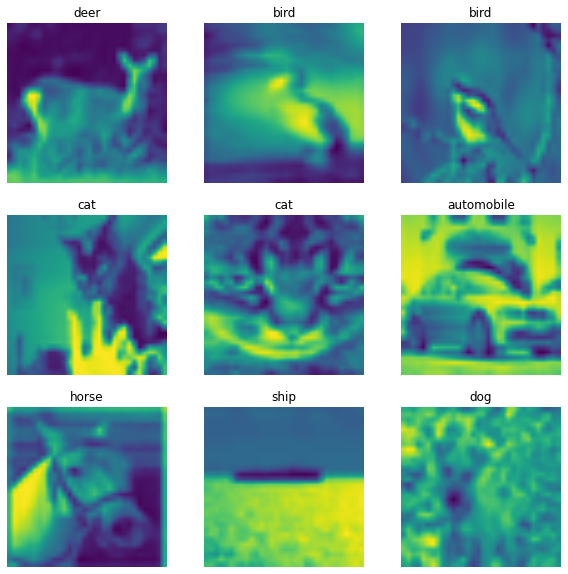

In [5]:
plt.figure(figsize=(10, 10))
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

for i in range(9):
    r = random.randint(0, 50000)
    ax = plt.subplot(3, 3, i + 1)
    image = train_data[r][0][0].numpy()
    label = train_data[r][1]
    plt.imshow(image)
    plt.title(labels[label])
    plt.axis("off")

## Loading and modifying the model

We define a function that loads a pre-trained [ResNet18](https://www.sciencedirect.com/topics/computer-science/residual-network#:~:text=ResNet18%20is%20a%2072%2Dlayer,a%20degradation%20of%20the%20output.) model, changes the last dense layer in that function, and returns it.

The functions receives the train and test dataloaders, the loss function, optimizer, devices and number of epochs and returns the trained model.

In [6]:
def make_ResNet18():
    model = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)

    for param in model.parameters():
        param.requires_grad = False   

    num_features=model.fc.in_features
    model.fc = nn.Sequential(
                    nn.Linear(num_features, 30),
                    nn.ReLU(),
                    nn.Linear(30, 10) 
                    )
    return model

We call this function to return the model. We also check if cuda is available and set the model for the device.

In [7]:
model = make_ResNet18()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Available device is {device}")

model = model.to(device)

Available device is cuda:0


We can check the model by prining it. The last two dense layers that we added are in 'fc' at the end of the model.

In [8]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Training the model

We create a function that make the training loop. The function receives the train and test dataloaders, loss function, optimizer, device, and number of epochs.

In [9]:
def train(model, trainloader, testloader, criterion, optimizer, device, epochs):
    print(f"Training the model on {device} for {epochs} epochs")
    image_dataset = {'train':trainloader, 'valid':testloader}
    loss_counter = 0
    
    for epoch in range(epochs):
        for phase in ['train', 'valid']:
            print(f"Epoch {epoch}, Phase {phase}")
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            running_samples=0

            for step, (inputs, labels) in enumerate(image_dataset[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase=='train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                running_samples+=len(inputs)
                
                if running_samples % 10000  == 0:
                    accuracy = running_corrects/running_samples
                    print("Images [{}/{} ({:.0f}%)] Loss: {:.2f} Accuracy: {}/{} ({:.2f}%)".format(
                            running_samples,
                            len(image_dataset[phase].dataset),
                            100.0 * (running_samples / len(image_dataset[phase].dataset)),
                            loss.item(),
                            running_corrects,
                            running_samples,
                            100.0*accuracy,
                        )
                    )
        

### Training, metrics, and optimizer

Now, we call the train function to train the model.

Since the last dense/linear layer of the model we created is logits and no activation is used, we pass cross-entropy loss for the criterion of optimization.

We also use Adam optimizer. We pass only the parameters from the last dense layers that we added to the Adam optimizer.


In [10]:
train (model = model, 
       trainloader = trainloader, 
       testloader  = testloader, 
       criterion   = nn.CrossEntropyLoss(), 
       optimizer   = optim.Adam(model.fc.parameters(), lr = 0.001), 
       device = device, 
       epochs = 3
       )

Training the model on cuda:0 for 3 epochs
Epoch 0, Phase train
Images [10000/50000 (20%)] Loss: 1.42 Accuracy: 5506/10000 (55.06%)
Images [20000/50000 (40%)] Loss: 0.86 Accuracy: 12154/20000 (60.77%)
Images [30000/50000 (60%)] Loss: 0.77 Accuracy: 19000/30000 (63.33%)
Images [40000/50000 (80%)] Loss: 0.53 Accuracy: 25928/40000 (64.82%)
Images [50000/50000 (100%)] Loss: 0.41 Accuracy: 32969/50000 (65.94%)
Epoch 0, Phase valid
Images [10000/10000 (100%)] Loss: 0.53 Accuracy: 7707/10000 (77.07%)
Epoch 1, Phase train
Images [10000/50000 (20%)] Loss: 0.67 Accuracy: 7128/10000 (71.28%)
Images [20000/50000 (40%)] Loss: 0.19 Accuracy: 14303/20000 (71.52%)
Images [30000/50000 (60%)] Loss: 0.42 Accuracy: 21451/30000 (71.50%)
Images [40000/50000 (80%)] Loss: 0.86 Accuracy: 28526/40000 (71.31%)
Images [50000/50000 (100%)] Loss: 0.59 Accuracy: 35726/50000 (71.45%)
Epoch 1, Phase valid
Images [10000/10000 (100%)] Loss: 0.48 Accuracy: 7813/10000 (78.13%)
Epoch 2, Phase train
Images [10000/50000 (20%)

## Improving the model

The best result we got with our added dense layers was around 80%. We unlock the last block of ResNet18 to see if it can improve the accuracy.

In [11]:
#unlock layer4 for optimization
for param in model.layer4.parameters():
    param.requires_grad = True

#create a new list of parameters to be sent to optimizer
params = list(model.fc.parameters()) + list(model.layer4.parameters())

#updata the optimizer
optimizer = optim.Adam(params, lr = 0.001)

#Train the model with the new parameters
train (model = model, 
       trainloader = trainloader, 
       testloader  = testloader, 
       criterion   = nn.CrossEntropyLoss(), 
       optimizer   = optimizer, 
       device      = device, 
       epochs = 3
       )

Training the model on cuda:0 for 3 epochs
Epoch 0, Phase train
Images [10000/50000 (20%)] Loss: 1.25 Accuracy: 6824/10000 (68.24%)
Images [20000/50000 (40%)] Loss: 1.15 Accuracy: 14508/20000 (72.54%)
Images [30000/50000 (60%)] Loss: 0.47 Accuracy: 22481/30000 (74.94%)
Images [40000/50000 (80%)] Loss: 0.33 Accuracy: 30588/40000 (76.47%)
Images [50000/50000 (100%)] Loss: 0.39 Accuracy: 38822/50000 (77.64%)
Epoch 0, Phase valid
Images [10000/10000 (100%)] Loss: 0.24 Accuracy: 8713/10000 (87.13%)
Epoch 1, Phase train
Images [10000/50000 (20%)] Loss: 0.64 Accuracy: 8430/10000 (84.30%)
Images [20000/50000 (40%)] Loss: 0.67 Accuracy: 16941/20000 (84.70%)
Images [30000/50000 (60%)] Loss: 0.26 Accuracy: 25553/30000 (85.18%)
Images [40000/50000 (80%)] Loss: 0.75 Accuracy: 34164/40000 (85.41%)
Images [50000/50000 (100%)] Loss: 1.02 Accuracy: 42841/50000 (85.68%)
Epoch 1, Phase valid
Images [10000/10000 (100%)] Loss: 0.16 Accuracy: 8855/10000 (88.55%)
Epoch 2, Phase train
Images [10000/50000 (20%)

That is great! We managed to improve the accuracy on the test dataset from 78% to 89% by unlocking the last block of the ResNet18. This increase was not because of higher number of epochs, if we increase the number of epochs on the previous model we can see that the accuracy does not improve.

We can go further and unlock more blocks. Even if we unlock all the blocks it may be still better to use the pre-trained weights as initial values of the weights.

For unlocking more layers, we need to be careful that we have enough training data.